Intro to the notebook, explanation of what we are doing. We should have a discussion of the cifar dataset, and the size of the images (32x32x3).

In [88]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np

from torchvision.datasets import mnist, cifar
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from random import sample
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


No need for much of an explanation for this one. This class is just to allow for loading of the data efficiently. There are some lines added to let it train faster, but the pictures aren't great anymore.

In [113]:
class DataLoad():
    
    def __init__(self):
        pass
    
    def load_data_mnist(self, batch_size=128):
        
        mnist_data = mnist.MNIST(root = './data/mnist',
                                train = True,
                                download = True,
                                transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])]))
        
        # Comment this line out if you wish to use the full dataset.
        mnist_data = torch.utils.data.Subset(mnist_data, sample(list(range(0,60000)), batch_size*100)) 
        
        mnist_loader = DataLoader(mnist_data, 
                                  batch_size = batch_size, 
                                  shuffle=True)
        
        return mnist_loader
    
    def load_data_cifar10(self, batch_size=128):
        
        cifar_data = cifar.CIFAR10(root = './data/cifar10',
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])]))
        
        # Comment these two lines out if you wish to use the full dataset.
        sample_range = sample(list(range(0,50000)), batch_size*120)
        cifar_data = torch.utils.data.Subset(cifar_data, sample_range)
        
        cifar_loader = DataLoader(cifar_data,
                                  batch_size = batch_size,
                                  shuffle = True)
        
        return cifar_loader        

In [117]:
def load_data(ds):
    
    # Initialize the dataloader
    data_loader = DataLoad()
    
    # Load training data into the dataloader
    if ds == 'mnist':
        train_loader = data_loader.load_data_mnist(batch_size = batch_size)
    elif ds == 'cifar10':
        train_loader = data_loader.load_data_cifar10(batch_size = batch_size)
    
    return train_loader



Here we should have a discussion of what we want the generator to be doing. I'll be removing the dimensions for the sequential parts, mainly the noise_dim part, unless you think we should remove a bit more of the internal part, but it might be too much to ask people to reconstruct it.

In [71]:
class Generator(nn.Module):
    
    def __init__(self, model_type, noise_dim=100):
        
        super(Generator, self).__init__()
        
        self.model_type = model_type
        self.image_shape = {'mnist': (1,28,28),
                           'cifar10': (3,32,32)}
        
        self.models = nn.ModuleDict({
            
            'mnist': nn.Sequential(
                            nn.Linear(noise_dim, 128, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(128,256, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,512, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512, 1024, bias=True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1024, int(np.prod(self.image_shape[model_type]))),
                            nn.Tanh()                
                            ),
            
            'cifar10': nn.Sequential(
                            nn.Linear(noise_dim, 128, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(128,256, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,512, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512, 1024, bias=True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1024, 2048, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(2048, int(np.prod(self.image_shape[model_type]))),
                            nn.Tanh()                
                            ),
                })
        
    def forward(self, z):
        img = self.models[self.model_type](z)
        img = img.view(img.size(0), *self.image_shape[self.model_type])            
        return img

Same as for the generator. Maybe give the option for how many layers they want to do?

In [72]:
class Discriminator(nn.Module):
    
    def __init__(self, model_type):
        
        super(Discriminator, self).__init__()
        
        self.model_type = model_type
        self.image_shape = {'mnist': (1,28,28),
                           'cifar10': (3,32,32)}
        
        self.models = nn.ModuleDict({
            'mnist': nn.Sequential(
                            nn.Linear(int(np.prod(self.image_shape[model_type])),512),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512,256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,1),
                            nn.Sigmoid(),
                ),
            
            'cifar10': nn.Sequential(
                            nn.Linear(int(np.prod(self.image_shape[model_type])),1024),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1024,512),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512,256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,1),
                            nn.Sigmoid(),
                ),
            })
        
    def forward(self, img):        
        img_flat = img.view(img.size(0),-1)
        output = self.models[self.model_type](img_flat)        
        return output

In [73]:
# This is just in case

cuda = True if torch.cuda.is_available() else False
device = 'cuda' if cuda else 'cpu'
device

In [ ]:
# Generate some fixed noise to use down the road.

fixed_noise = torch.randn(16, noise_dim, device=device)

# Set real/fake designations:

real = float(1)
fake = float(0)

All of the Nones below need to be filled in. Play around with the values, and see what works. The _k_ below is the _k_ from the paper.

In [74]:
# Input arguments in this block
batch_size = 128
beta1 = 0.5
beta2 = 0.999
dataset = 'cifar10'

total_epochs = None
learning_rate = None
noise_dim = None
k = None

In [ ]:
# Load training data:
dataset = 'cifar10' # 'mnist' or 'cifar10'
train_loader = load_data(dataset)

In [38]:
# Loss function

criterion = torch.nn.BCELoss()

# Initialize generator and discriminator

generator = Generator(dataset)
discriminator = Discriminator(dataset)

if cuda:
    generator.cuda()
    discriminator.cuda()
    criterion.cuda()

# Optimizers

optimizer_generator = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (beta1, beta2))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (beta1, beta2))

This is probably where we want a reiteration of the loss function game. I'm going to have the next section filled with a lot of blank/Nones , since it should be relatively straightforward and then people can fill them in.

[4/200]	Loss_D: 0.9901	Loss_G: 3.5707	D(x): 0.0500	
[8/200]	Loss_D: 0.7149	Loss_G: 2.3485	D(x): 0.1460	
[12/200]	Loss_D: 0.9922	Loss_G: 2.2204	D(x): 0.1380	
[16/200]	Loss_D: 0.6959	Loss_G: 2.2816	D(x): 0.1215	
[20/200]	Loss_D: 0.8549	Loss_G: 1.9310	D(x): 0.1632	
[24/200]	Loss_D: 0.9915	Loss_G: 1.7131	D(x): 0.2090	
[28/200]	Loss_D: 0.9004	Loss_G: 2.0941	D(x): 0.1625	
[32/200]	Loss_D: 0.9377	Loss_G: 1.6628	D(x): 0.2210	
[36/200]	Loss_D: 0.9686	Loss_G: 1.7756	D(x): 0.2251	
[40/200]	Loss_D: 0.9631	Loss_G: 1.8503	D(x): 0.1931	
[44/200]	Loss_D: 1.0507	Loss_G: 1.2680	D(x): 0.3184	
[48/200]	Loss_D: 1.0043	Loss_G: 1.7154	D(x): 0.2210	
[52/200]	Loss_D: 0.9555	Loss_G: 1.8446	D(x): 0.1898	
[56/200]	Loss_D: 1.0514	Loss_G: 1.5861	D(x): 0.2455	
[60/200]	Loss_D: 0.9814	Loss_G: 1.6945	D(x): 0.2201	
[64/200]	Loss_D: 1.2231	Loss_G: 1.4068	D(x): 0.2895	
[68/200]	Loss_D: 1.2840	Loss_G: 1.3047	D(x): 0.3274	
[72/200]	Loss_D: 1.2548	Loss_G: 1.5346	D(x): 0.2608	
[76/200]	Loss_D: 1.1001	Loss_G: 1.7735	D(x): 0.2

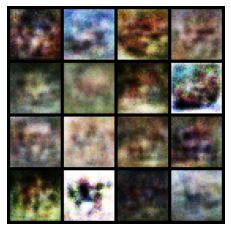

In [116]:
# Training Loop

for epoch in range(total_epochs):
    # update the discriminator k times before updating the generator
    for i, (imgs, _) in enumerate(train_loader):
        
        
        
        imgs = imgs.to(device)
        
        # Set up some 'truth' variables here so that way the discriminator has something to check against.
        
        valid = Variable(torch.Tensor(imgs.size(0),1).fill_(None), requires_grad=False).to(device)
        false = Variable(torch.Tensor(imgs.size(0),1).fill_(None), requires_grad=False).to(device)
        
        optimizer_discriminator.zero_grad()
        
        # Calculate the loss on the all-real batch
        # What do we want to be comparing our discriminator against?
        
        real_loss = criterion(discriminator(imgs), None)
        
        # Generate some random noise
        # What kind of distribution do we want to be using for this? (replace the None in the next line with the answer)
        
        noise = Variable(torch.Tensor(np.random.None(0,1, (imgs.shape[0], noise_dim)))).to(device)
        
        # We want some fake images here from the noise, how would we create them?
        gen_imgs = None
        
        # Now we examine how well our discriminator does against the false data, so thus
        fake_loss = criterion(discriminator(gen_imgs.detach()), false)
        
        # Now we need to have the loss for our discriminator. How would we do this?
        
        loss_D = None
        
        # Calculate the gradients        
        loss_D.backward()
        
        # Update D
        optimizer_discriminator.step()
        
        
        # Update generator network: maximize log(D(G(z)))
        # This only fires after k steps of discriminator optimization
        
        if (epoch+1)%k == 0:
            optimizer_generator.zero_grad()

            # We need to now update our generator. What would the first step here?

            gen_imgs = None
            output = None

            # Now we need to calculate the probability of the discriminator classifying the fake images as real
            # If this probability is close to 0, then the generator has learnt how to fool the discriminator

            D_x = output.mean().item()

            # What information would we want to have in order to properly update our generator?

            loss_G = criterion(output, None)
            
            # Calculate gradients for the generator:
            loss_G.backward()

            # Update  the generator
            optimizer_generator.step()

    if (epoch+1) % 4 == 0:

        # Output the training stats
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\t'
                % (epoch+1, total_epochs, 
                    loss_D.item(),
                    loss_G.item(),
                    D_x)) 

(-0.5, 137.5, 137.5, -0.5)

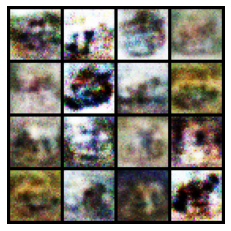

In [ ]:
# Here we can use the fixed noise in order to use the generator to generate some images

fake_sample = generator(fixed_noise)
image_grid = make_grid(fake_sample.to(device),
                                       padding=2,
                                       nrow=4,
                                       normalize = True)
plt.imshow(image_grid.cpu().permute(1,2,0))
plt.axis('off')

You will notice that while there does seem to be blurry shapes that if you squint at, you can kind of see some shapes, but they are still mostly blurs. This is an issue that comes down to dataset size and computational time. As an additional exercise, we an examination of the mnist dataset.

(Max, we can just add something else for them to do here. I don't really have much else to work on here.)